In [53]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

## Deep learning models

In [ ]:
import zipfile

with zipfile.ZipFile("../data/cleaned/resale_price_clean_final.csv.zip", 'r') as zip_ref:
    file_name = zip_ref.namelist()[0] 
    with zip_ref.open(file_name) as file:
        df_resale = pd.read_csv(file)

In [55]:
df_resale = df_resale = pd.read_csv("../data/cleaned/resale_price_cleaned_final.csv")

FileNotFoundError: [Errno 2] No such file or directory: '../data/cleaned/resale_price_cleaned_final.csv'

In [ ]:
df_resale

In [ ]:
df_resale['month'] = pd.to_datetime(df_resale['month'])
df_resale['year'] = df_resale['month'].dt.year
df_resale['month'] = df_resale['month'].dt.year

/var/folders/pf/xn094ngs70lb3jh0xpvlzx8c0000gn/T/ipykernel_1046/2757938304.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


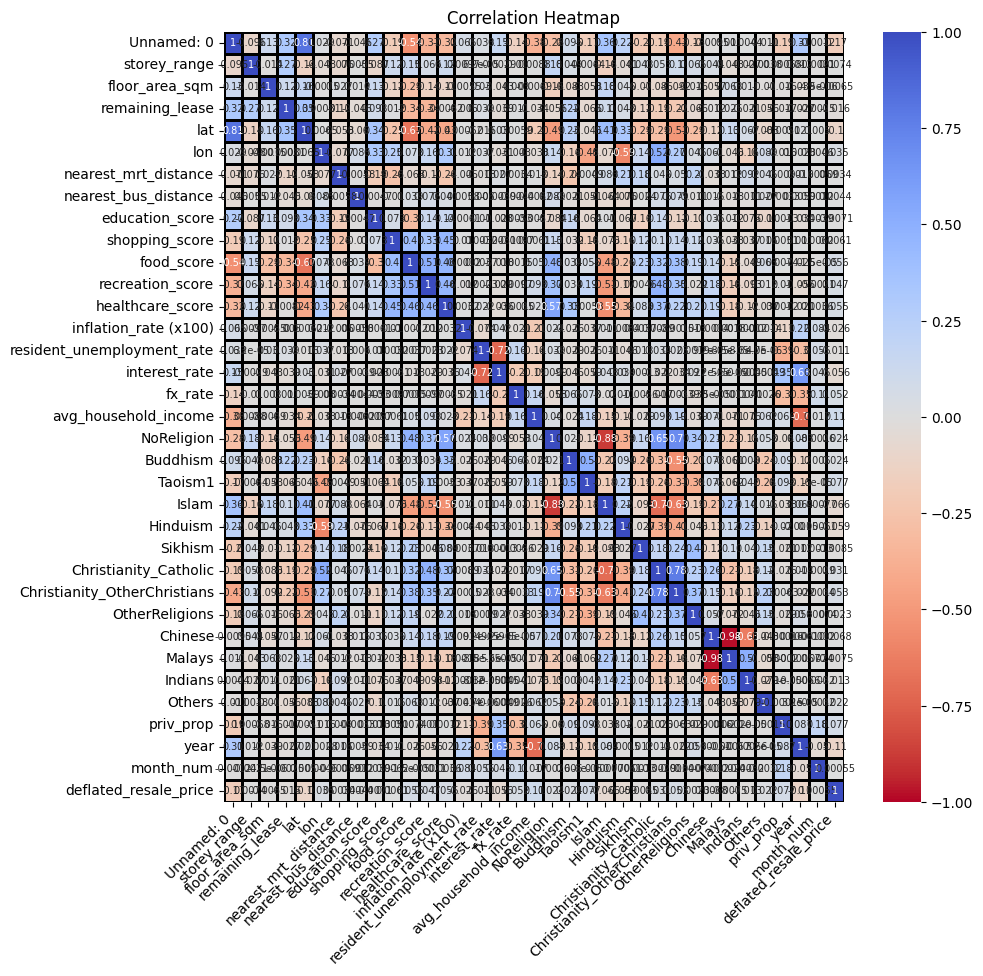

In [ ]:
# # Correlation heatmap
# fig = plt.figure(figsize=(10,10))
# ax = sns.heatmap(df_resale.select_dtypes(include=['int64','float64']).corr(), annot = True, fmt='.2g', 
#     vmin=-1, vmax=1, center= 0, cmap= 'coolwarm_r', linecolor='black', linewidth=1, annot_kws={"size": 7})
# plt.xticks(rotation=45, ha='right')
# plt.title('Correlation Heatmap')
# fig.show()

In [45]:
df_resale = df_resale.drop(columns=['flat_type','flat_model','building_age_2025'])

In [46]:
df_resale = pd.get_dummies(df_resale, columns=['town'], prefix='town')

## Preprocessing

In [47]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X = df_resale.drop(columns=['resale_price'])
y = df_resale['resale_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_rnn = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_rnn = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))


## Model Definition

### Simple Neural Network

In [48]:
nn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

nn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
nn_model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=0)

nn_predictions = nn_model.predict(X_test_scaled)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1232/1232 ━━━━━━━━━━━━━━━━━━━━ 0s 231us/step


### RNN

In [ ]:
rnn_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(50, activation='relu', input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
    tf.keras.layers.Dense(1)
])

rnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
rnn_model.fit(X_train_rnn, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

# Predictions
rnn_predictions = rnn_model.predict(X_test_rnn)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1232/1232 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


### LSTM

In [50]:
lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, activation='tanh', return_sequences=True, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
    tf.keras.layers.LSTM(50, activation='tanh'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

lstm_model.fit(X_train_rnn, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping])


Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3940/3940 ━━━━━━━━━━━━━━━━━━━━ 5s 909us/step - loss: 0.0086 - mae: 0.0543 - val_loss: 0.0034 - val_mae: 0.0472
Epoch 2/10
3940/3940 ━━━━━━━━━━━━━━━━━━━━ 3s 782us/step - loss: 0.0014 - mae: 0.0266 - val_loss: 0.0013 - val_mae: 0.0282
Epoch 3/10
3940/3940 ━━━━━━━━━━━━━━━━━━━━ 3s 785us/step - loss: 0.0011 - mae: 0.0244 - val_loss: 0.0027 - val_mae: 0.0420
Epoch 4/10
3940/3940 ━━━━━━━━━━━━━━━━━━━━ 3s 828us/step - loss: 0.0010 - mae: 0.0236 - val_loss: 0.0036 - val_mae: 0.0475
Epoch 5/10
3940/3940 ━━━━━━━━━━━━━━━━━━━━ 3s 838us/step - loss: 9.7941e-04 - mae: 0.0229 - val_loss: 0.0038 - val_mae: 0.0487
Epoch 6/10
3940/3940 ━━━━━━━━━━━━━━━━━━━━ 3s 848us/step - loss: 9.4540e-04 - mae: 0.0225 - val_loss: 0.0032 - val_mae: 0.0447
Epoch 7/10
3940/3940 ━━━━━━━━━━━━━━━━━━━━ 3s 798us/step - loss: 8.8944e-04 - mae: 0.0220 - val_loss: 0.0037 - val_mae: 0.0470
Epoch 8/10
3940/3940 ━━━━━━━━━━━━━━━━━━━━ 3s 799us/step - loss: 8.5887e-04 - mae: 0.0216 - val_loss: 0.0030 - val_mae: 0.0421
Epoch 9/10
3940/394

In [51]:
# Predictions
lstm_predictions = lstm_model.predict(X_test_rnn)

1232/1232 ━━━━━━━━━━━━━━━━━━━━ 1s 428us/step


## Evaluation

In [52]:
def evaluate_model(true_values, predictions):
    r2 = r2_score(true_values, predictions)
    rmse = np.sqrt(mean_squared_error(true_values, predictions))
    mae = mean_absolute_error(true_values, predictions)
    return r2, rmse, mae

nn_r2, nn_rmse, nn_mae = evaluate_model(y_test, nn_predictions)
print(f"Neural Network - R²: {nn_r2:.4f}, RMSE: {nn_rmse:.4f}, MAE: {nn_mae:.4f}")

rnn_r2, rnn_rmse, rnn_mae = evaluate_model(y_test, rnn_predictions)
print(f"RNN - R²: {rnn_r2:.4f}, RMSE: {rnn_rmse:.4f}, MAE: {rnn_mae:.4f}")

lstm_r2, lstm_rmse, lstm_mae = evaluate_model(y_test, lstm_predictions)
print(f"LSTM - R²: {lstm_r2:.4f}, RMSE: {lstm_rmse:.4f}, MAE: {lstm_mae:.4f}")


Neural Network - R²: 0.9082, RMSE: 0.0289, MAE: 0.0219
RNN - R²: 0.7378, RMSE: 0.0488, MAE: 0.0399
LSTM - R²: 0.7992, RMSE: 0.0427, MAE: 0.0327


Without year and month data

Neural Network - R²: 0.8041, RMSE: 0.0422, MAE: 0.0316
RNN - R²: 0.8261, RMSE: 0.0397, MAE: 0.0312
LSTM - R²: 0.5895, RMSE: 0.0611, MAE: 0.0474

With:

Neural Network - R²: 0.9082, RMSE: 0.0289, MAE: 0.0219
RNN - R²: 0.7378, RMSE: 0.0488, MAE: 0.0399
LSTM - R²: 0.7992, RMSE: 0.0427, MAE: 0.0327